## Cryptocurrency Time Series - Analysis
In this notebook, I will be using the functions I made to generate custom stock/cryptocurrency tables and analyze them together and with exogenous factors. I will then compare and contrast some of the models and see how well each does.

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set()

import time
from datetime import datetime
from datetime import date
from datetime import timedelta
import scipy
import scipy.stats
import pylab
import statsmodels.api as sm
#sklearn

import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import OCSBTest
from arch import arch_model
from scipy.stats.distributions import chi2 

import yfinance
from yahoo_fin.stock_info import get_data
from Time_Series_Functions import get_close_column, get_volume_column, create_ticker_table
import warnings
warnings.filterwarnings('ignore')

In [11]:
example_df = create_ticker_table()

Enter a ticker from Yahoo! Finance. Enter "No" to continue: BTC-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: no
Do you want daily or business day data? Enter 'd' for daily and 'b' for business: d

********** Table Head **********


,BTC-USD_Close,BTC-USD_Volume,BTC-USD_Return
2017-01-02,1021.750000,222184992,0.000000
2017-01-03,1043.839966,185168000,2.161974
2017-01-04,1154.729980,344945984,10.623277
2017-01-05,1013.380005,510199008,-12.240955
2017-01-06,902.200989,351876000,-10.971108
2017-01-07,908.585022,279550016,0.707607
2017-01-08,911.198975,158715008,0.287695
2017-01-09,902.828003,141876992,-0.918677
2017-01-10,907.679016,115808000,0.537313
2017-01-11,777.757019,310928992,-14.313650


********** Table Tail **********


,BTC-USD_Close,BTC-USD_Volume,BTC-USD_Return
2022-04-20,41374.378906,27819532341,-0.309307
2022-04-21,40527.363281,35372786395,-2.047198
2022-04-22,39740.320312,28011716745,-1.942004
2022-04-23,39486.730469,16138021249,-0.638117
2022-04-24,39469.292969,17964398167,-0.044160
2022-04-25,40458.308594,35445730570,2.505785
2022-04-26,38117.460938,34569088416,-5.785827
2022-04-27,39241.121094,30981015184,2.947888
2022-04-28,39773.828125,33903704907,1.357522
2022-04-29,38609.824219,30882994649,-2.926557


 ### LLR Test
To test for coefficient significance of the models we'll make, we'll create a Log-Liklihood Ratio test to measure the p values of the model. We can use this as a checkpoint for if we ought to try higher order models or not:

In [9]:
def LLR_test(model_1, model_2, df = 1):
    """
    This function generates a p-value for which to judge the significance of the model on.
    
    args:
        model_1 (Object): The first model to compare coefficients with
        model_2 (Object): The second model to compare coefficients with
    
    returns:
        p-value (float): The measure of model significance used to decide if we should create higher order models
    
    
    """
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    
    LR = (2*(L2-L1))    
    p_value = chi2.sf(LR, df).round(3)
    
    return p_value

### Differncing Function
Implementing this function in order to make non-stationary data stationary.

In [216]:
def make_difference(df, interval=1):
    diff = list()
    for i in range(interval, len(df)):
        value = df[i] - df[i - interval]
        diff.append(value)
        
    return pd.Series(diff)

In [38]:
crypto_df = create_ticker_table()

Enter a ticker from Yahoo! Finance. Enter "No" to continue: BTC-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: DOGE-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: SHIB-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: ETH-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: DOT-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: USDT-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: LTC-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: TRX-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: STETH-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: no
Do you want daily or business day data? Enter 'd' for daily and 'b' for business: bb
Please enter again: b

********** Table Head **********


,BTC-USD_Close,DOGE-USD_Close,SHIB-USD_Close,ETH-USD_Close,DOT-USD_Close,USDT-USD_Close,LTC-USD_Close,TRX-USD_Close,STETH-USD_Close,BTC-USD_Volume,...,STETH-USD_Volume,BTC-USD_Return,DOGE-USD_Return,SHIB-USD_Return,ETH-USD_Return,DOT-USD_Return,USDT-USD_Return,LTC-USD_Return,TRX-USD_Return,STETH-USD_Return
2020-12-23,23241.345703,0.003768,0.0,583.714600,4.710613,0.999426,101.817062,0.024820,588.655334,51146161904,...,64860.0,-2.277606,-16.415258,0.0,-8.055328,-8.617495,-0.021507,-10.435667,-14.099813,0.000000
2020-12-24,23735.949219,0.004570,0.0,611.607178,5.128821,0.999931,111.565399,0.027697,611.787476,41080759713,...,53526.0,2.128119,21.284496,0.0,4.778462,8.877998,0.050526,9.574365,11.591461,3.929658
2020-12-25,24664.791016,0.004582,0.0,626.410706,5.214210,1.000168,126.983597,0.028497,626.136230,42068395846,...,45601.0,3.913228,0.262584,0.0,2.420431,1.664888,0.023700,13.819874,2.888394,2.345382
2020-12-28,27084.808594,0.004592,0.0,730.397339,6.588822,0.998603,130.050339,0.029532,727.073669,49056742893,...,2304.0,9.811628,0.218247,0.0,16.600392,26.362802,-0.156472,2.415069,3.631965,16.120683
2020-12-29,27362.437500,0.004486,0.0,731.520142,7.519257,0.998590,129.040802,0.027690,720.873047,45265946774,...,116889.0,1.025036,-2.308360,0.0,0.153725,14.121420,-0.001301,-0.776266,-6.237300,-0.852819
2020-12-30,28840.953125,0.004636,0.0,751.618958,7.254300,1.000275,129.466080,0.026945,720.616577,51287442704,...,95180.0,5.403450,3.343730,0.0,2.747541,-3.523712,0.168740,0.329568,-2.690503,-0.035578
2020-12-31,29001.720703,0.004682,0.0,737.803406,9.292508,1.000598,124.690323,0.026833,731.029663,46754964848,...,81185.0,0.557428,0.992232,0.0,-1.838106,28.096549,0.032285,-3.688809,-0.415665,1.445024
2021-01-01,29374.152344,0.005685,0.0,730.367554,8.306819,1.001916,126.230347,0.026940,722.167175,40730301359,...,5093.0,1.284171,21.422479,0.0,-1.007837,-10.607353,0.131731,1.235079,0.398761,-1.212329
2021-01-04,31971.914062,0.009767,0.0,1040.233032,9.469611,1.000128,154.807327,0.030853,991.251221,81163475344,...,289731.0,8.843699,71.802977,0.0,42.425964,13.998044,-0.178460,22.638756,14.524871,37.260631
2021-01-05,33992.429688,0.009920,0.0,1100.006104,9.701656,1.002202,158.594772,0.028632,1103.261230,67547324782,...,425083.0,6.319658,1.566504,0.0,5.746123,2.450419,0.207374,2.446554,-7.198650,11.299861


********** Table Tail **********


,BTC-USD_Close,DOGE-USD_Close,SHIB-USD_Close,ETH-USD_Close,DOT-USD_Close,USDT-USD_Close,LTC-USD_Close,TRX-USD_Close,STETH-USD_Close,BTC-USD_Volume,...,STETH-USD_Volume,BTC-USD_Return,DOGE-USD_Return,SHIB-USD_Return,ETH-USD_Return,DOT-USD_Return,USDT-USD_Return,LTC-USD_Return,TRX-USD_Return,STETH-USD_Return
2022-04-14,39935.515625,0.143920,0.000026,3019.909424,20.252199,1.000127,107.411041,0.060132,3019.633301,24342001973,...,824553.0,-2.990801,2.741290,-3.703705,-3.156637,0.000000,-0.014802,-2.779999,-2.248231,-2.698086
2022-04-15,40553.464844,0.146026,0.000026,3040.916504,20.252199,1.000239,111.109344,0.061889,3033.466797,21756855753,...,198529.0,1.547368,1.463310,0.000000,0.695620,0.000000,0.011204,3.443131,2.921905,0.458118
2022-04-18,40826.214844,0.140286,0.000025,3057.606689,20.252199,1.000218,111.226143,0.061561,3054.893311,33705182072,...,506145.0,0.672569,-3.930808,-3.846155,0.548854,0.000000,-0.002098,0.105120,-0.529982,0.706338
2022-04-19,41502.750000,0.142665,0.000025,3104.106445,20.252199,1.000343,113.812088,0.063368,3097.314209,25303206547,...,297473.0,1.657110,1.695822,0.000000,1.520789,0.000000,0.012490,2.324944,2.935301,1.388621
2022-04-20,41374.378906,0.140878,0.000025,3077.745850,20.252199,1.000202,111.979691,0.062642,3048.782471,27819532341,...,310944.0,-0.309307,-1.252579,0.000000,-0.849217,0.000000,-0.014098,-1.610020,-1.145688,-1.566897
2022-04-21,40527.363281,0.136365,0.000024,2987.480713,20.252199,1.000157,106.997986,0.071457,2964.113525,35372786395,...,431199.0,-2.047198,-3.203488,-3.999994,-2.932833,0.000000,-0.004493,-4.448757,14.072025,-2.777140
2022-04-22,39740.320312,0.136395,0.000024,2964.835693,20.252199,1.000234,105.600624,0.066790,2956.539307,28011716745,...,341243.0,-1.942004,0.022008,0.000000,-0.757997,0.000000,0.007700,-1.305970,-6.531199,-0.255531
2022-04-25,40458.308594,0.157959,0.000024,3009.393555,20.252199,1.000145,104.687019,0.065331,3002.082764,35445730570,...,871485.0,1.806700,15.809957,0.000000,1.502878,0.000000,-0.008903,-0.865151,-2.184462,1.540431
2022-04-26,38117.460938,0.137767,0.000023,2808.298340,20.252199,1.000073,98.404678,0.061920,2799.362061,34569088416,...,732428.0,-5.785827,-12.783062,-4.166668,-6.682250,0.000000,-0.007199,-6.001070,-5.221103,-6.752669
2022-04-27,39241.121094,0.139700,0.000023,2888.929688,16.948017,1.000153,100.538757,0.063221,2883.189941,30981015184,...,427442.0,2.947888,1.403089,0.000000,2.871182,-16.315177,0.007998,2.168676,2.101101,2.994535


### Cryptocurrency Prices around the Russian Invasion

We'll start by plotting all of the cryptocurrencies of interest and then start with basic models of a chosen currency and build from there.

I have chosen 8 currencies. We can see how each currency has trended since the earliest period of data where all chosen cryptocurrencies have data.

Since we are analyzing this data in tandem with the date of Russia's invasion, I will split the plots on that date. Since the currencies chosen are all on widely different price ranges, I will plot them separately.

The Date that Ukraine was invaded that will be annotated below is <b>February 24th, 2022</b>.

In [39]:
invasion_date = "2022-02-24"

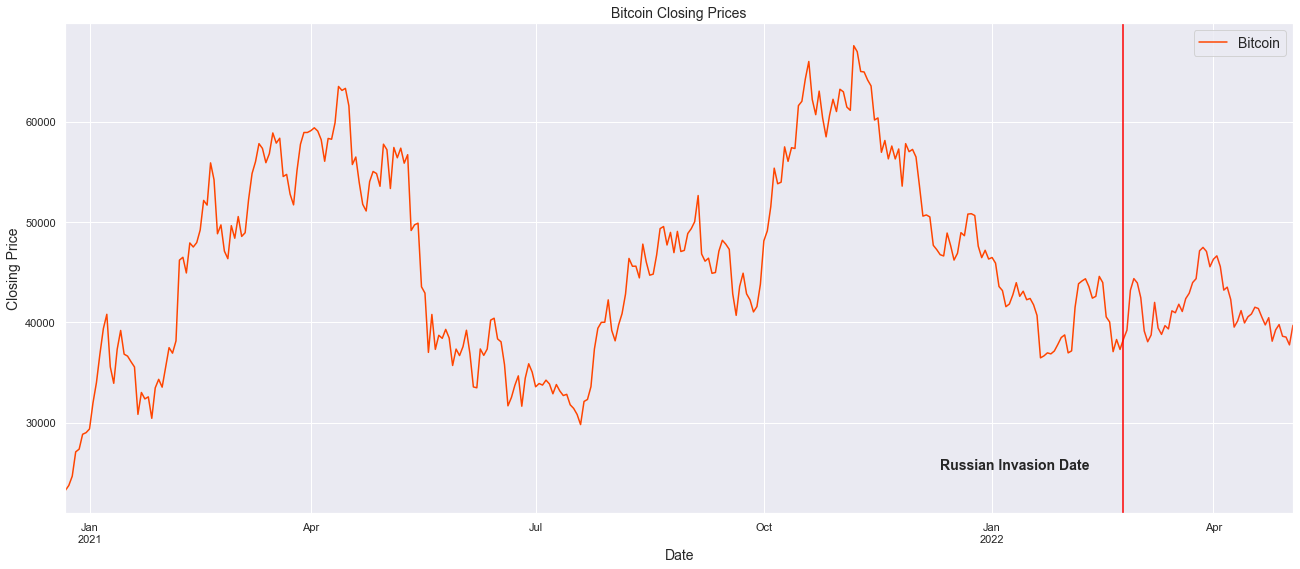

In [153]:
crypto_df['BTC-USD_Close'][:invasion_date].plot(figsize=(22,9), color='#FF4500')

crypto_df['BTC-USD_Close'][invasion_date:].plot(color='#FE420F')

plt.legend(['Bitcoin'], fontsize=14)
plt.axvline(x=invasion_date, ymin=0, ymax=70000, color='red')
plt.title('Bitcoin Closing Prices', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

plt.annotate('Russian Invasion Date',
            xy=(940, 100), xycoords='figure pixels', weight='bold', fontsize=14)

plt.show()

In [101]:
crypto_df['date'] = crypto_df.index

It's more straightforward to use matplotlib graphics since we have a lot of splitting to do with different dates, so I will rely on that graphing library.

In [102]:
#before_crypto_df = crypto_df[crypto_df.index<=invasion_date]
#after_crypto_df = crypto_df[crypto_df.index>invasion_date]


In [103]:
#fig = go.Figure()

#fig.add_trace(go.Scatter(x=before_crypto_df['date'], y=before_crypto_df['BTC-USD_Close']))
#fig.add_trace(go.Scatter(x=after_crypto_df['date'], y=after_crypto_df['BTC-USD_Close']))
#fig = px.line(after_crypto_df, x='date', y='BTC-USD_Close')
#fig.show()

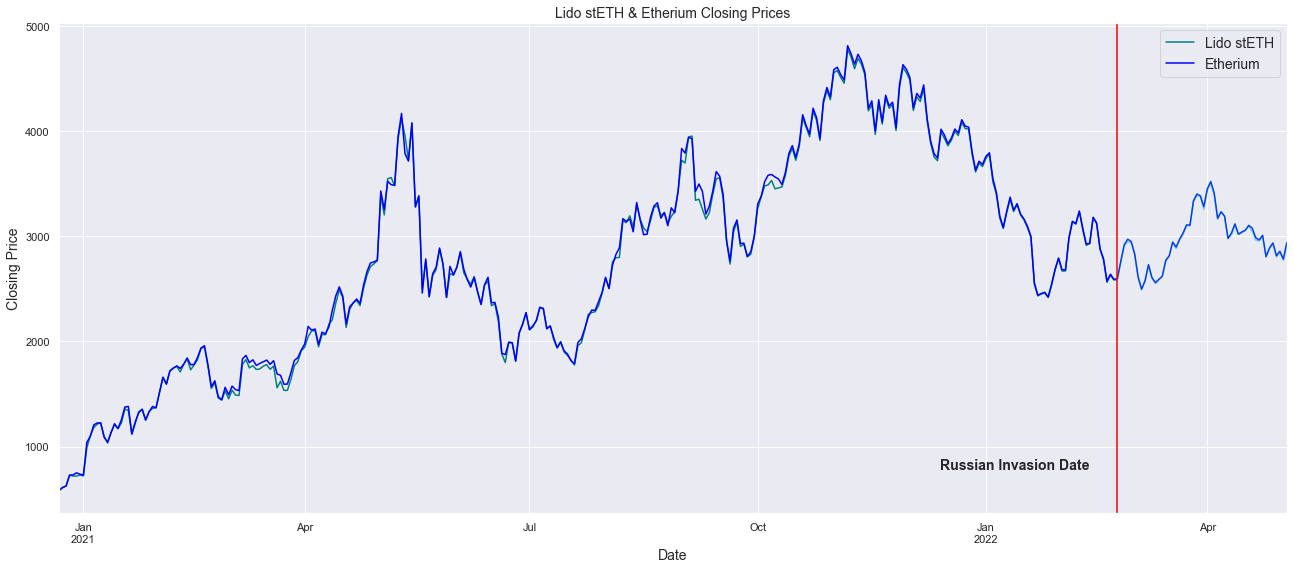

In [150]:
crypto_df['STETH-USD_Close'][:invasion_date].plot(figsize=(22, 9), color='#008080')
crypto_df['ETH-USD_Close'][:invasion_date].plot(color='#0000FF')

crypto_df['STETH-USD_Close'][invasion_date:].plot(color='#7BC8F6')
crypto_df['ETH-USD_Close'][invasion_date:].plot(color='#0343DF')

plt.legend(['Lido stETH', 'Etherium'], fontsize=14)
plt.axvline(x=invasion_date, ymin=0, ymax=70000, color='red')
plt.title('Lido stETH & Etherium Closing Prices', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

plt.annotate('Russian Invasion Date',
            xy=(940, 100), xycoords='figure pixels', weight='bold', fontsize=14)

plt.show()

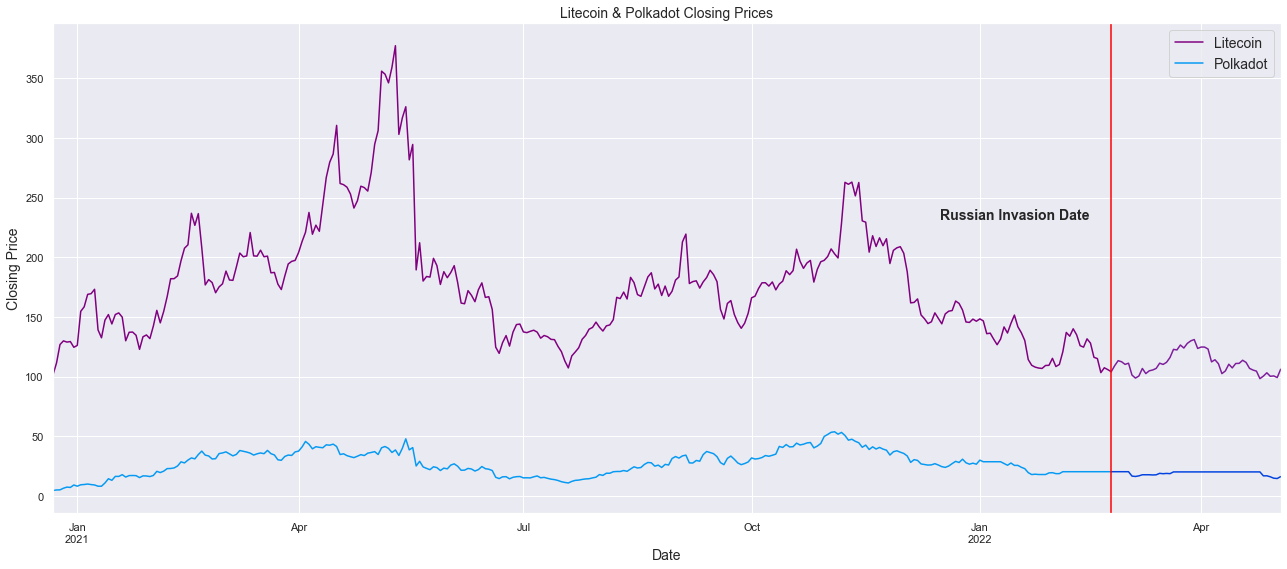

In [149]:
crypto_df['LTC-USD_Close'][:invasion_date].plot(figsize=(22, 9),color='#800080')
crypto_df['DOT-USD_Close'][:invasion_date].plot(color='#069AF3')

crypto_df['LTC-USD_Close'][invasion_date:].plot(color='#7E1E9C')
crypto_df['DOT-USD_Close'][invasion_date:].plot(color='#0343DF')

plt.legend(['Litecoin', 'Polkadot'], fontsize=14)
plt.axvline(x=invasion_date, ymin=0, ymax=70000, color='red')
plt.title('Litecoin & Polkadot Closing Prices', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

plt.annotate('Russian Invasion Date',
            xy=(940, 350), xycoords='figure pixels', weight='bold', fontsize=14)

plt.show()

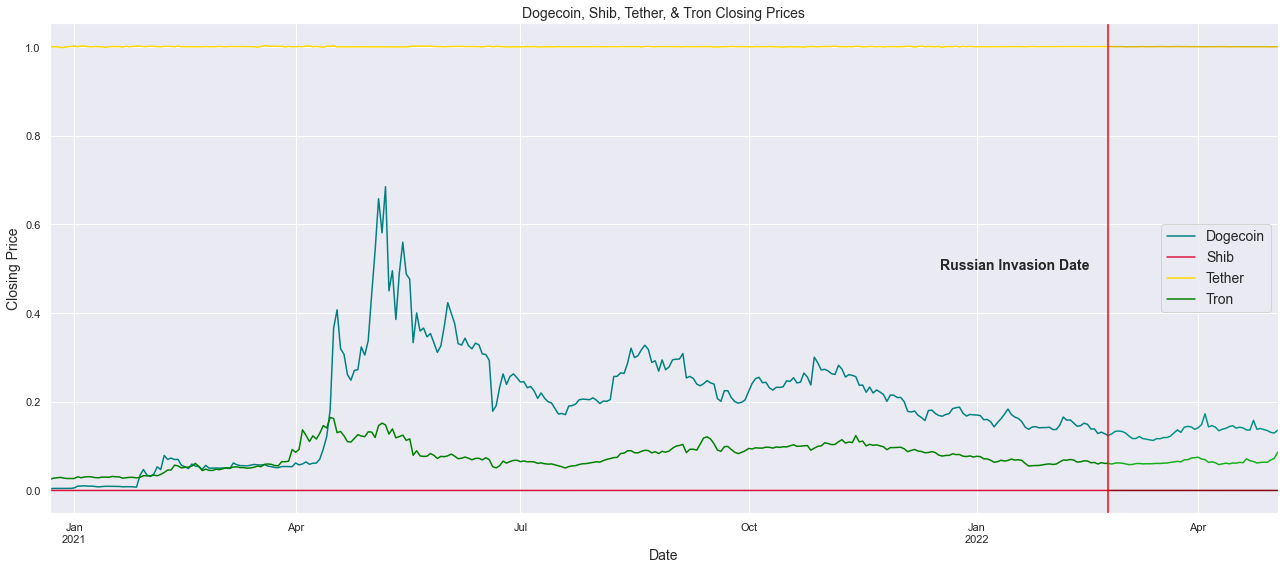

In [146]:
crypto_df['DOGE-USD_Close'][:invasion_date].plot(figsize=(22, 9), color='#008080')
crypto_df['SHIB-USD_Close'][:invasion_date].plot(color='#DC143C')
crypto_df['USDT-USD_Close'][:invasion_date].plot(color='#FFD700')
crypto_df['TRX-USD_Close'][:invasion_date].plot(color='#008000')

crypto_df['DOGE-USD_Close'][invasion_date:].plot(color='#029386')
crypto_df['SHIB-USD_Close'][invasion_date:].plot(color='#8C000F')
crypto_df['USDT-USD_Close'][invasion_date:].plot(color='#DBB40C')
crypto_df['TRX-USD_Close'][invasion_date:].plot(color='#15B01A')

#plt.ylim([0, 40])
plt.legend(['Dogecoin', 'Shib', 'Tether', 'Tron'], fontsize=14)
plt.axvline(x=invasion_date, ymin=0, ymax=70000, color='red')
plt.title('Dogecoin, Shib, Tether, & Tron Closing Prices', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

plt.annotate('Russian Invasion Date',
            xy=(940, 300), xycoords='figure pixels', weight='bold', fontsize=14)

plt.show()

We can see that since the Russian invasion of Ukraine, each of our chosen currencies have stagnated around some range. What is also interesting is some of the currencies rise and fall together around the beginning of April, so we could include each currency as some exogenous factors to one we model. Several of the currencies seem to have dipped in the 4th quarter of 2021 as well.

Even Bitcoin has remained within a range for several months despite before being quite a volatile currency.

Let's now take a look at some commodities and plot their changes.

In [165]:
coms_df = create_ticker_table(start_date="2020-12-22")

#https://www.barrons.com/articles/scared-about-stocks-thats-your-signal-to-start-buying-51651731300

Enter a ticker from Yahoo! Finance. Enter "No" to continue: CL=F
Enter a ticker from Yahoo! Finance. Enter "No" to continue: NG=F
Enter a ticker from Yahoo! Finance. Enter "No" to continue: no
Do you want daily or business day data? Enter 'd' for daily and 'b' for business: b

********** Table Head **********


,CL=F_Close,NG=F_Close,CL=F_Volume,NG=F_Volume,CL=F_Return,NG=F_Return
2020-12-23,48.119999,2.608,344306.0,98707.0,0.000000,0.000000
2020-12-24,48.230000,2.518,167390.0,39990.0,0.228596,-3.450926
2020-12-25,48.230000,2.518,167390.0,39990.0,0.000000,0.000000
2020-12-28,47.619999,2.305,238462.0,49279.0,-1.264774,-8.459088
2020-12-29,48.000000,2.467,213778.0,143530.0,0.797986,7.028197
2020-12-30,48.400002,2.422,266957.0,81788.0,0.833337,-1.824081
2020-12-31,48.520000,2.539,181894.0,111108.0,0.247932,4.830723
2021-01-01,48.520000,2.539,181894.0,111108.0,0.000000,0.000000
2021-01-04,47.619999,2.581,528525.0,128377.0,-1.854908,1.654197
2021-01-05,49.930000,2.702,643191.0,149828.0,4.850906,4.688098


********** Table Tail **********


,CL=F_Close,NG=F_Close,CL=F_Volume,NG=F_Volume,CL=F_Return,NG=F_Return
2022-04-13,104.250000,6.997,312502.0,210551.0,3.628232,4.745515
2022-04-14,106.949997,7.300,244952.0,214218.0,2.589925,4.330427
2022-04-15,106.949997,7.300,244952.0,214218.0,0.000000,0.000000
2022-04-18,108.209999,7.820,68489.0,191084.0,1.178123,7.123287
2022-04-19,102.559998,7.176,71792.0,236995.0,-5.221330,-8.235295
2022-04-20,102.750000,6.937,299028.0,157958.0,0.185260,-3.330551
2022-04-21,103.790001,6.957,280321.0,145263.0,1.012166,0.288309
2022-04-22,102.070000,6.534,246116.0,80599.0,-1.657194,-6.080205
2022-04-25,98.540001,6.669,328153.0,32516.0,-3.458410,2.066119
2022-04-26,101.699997,6.850,351850.0,41407.0,3.206816,2.714046


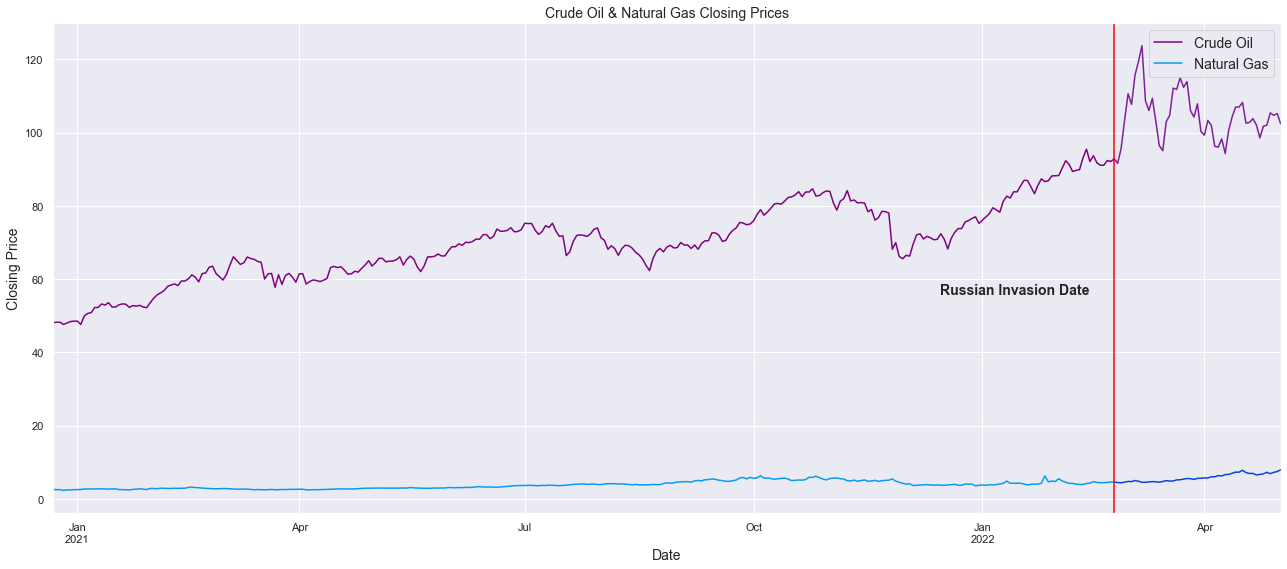

In [170]:
coms_df['CL=F_Close'][:invasion_date].plot(figsize=(22, 9),color='#800080')
coms_df['NG=F_Close'][:invasion_date].plot(color='#069AF3')

coms_df['CL=F_Close'][invasion_date:].plot(color='#7E1E9C')
coms_df['NG=F_Close'][invasion_date:].plot(color='#0343DF')


plt.legend(['Crude Oil', 'Natural Gas'], fontsize=14)
plt.axvline(x=invasion_date, ymin=0, ymax=70000, color='red')
plt.title('Crude Oil & Natural Gas Closing Prices', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

plt.annotate('Russian Invasion Date',
            xy=(940, 275), xycoords='figure pixels', weight='bold', fontsize=14)

plt.show()

We can see Crude Oil has raised in price, but Natural Gas has remained steady. Crude Oil has steadily increased over the past year, and became more volatile once Russian invaded Ukraine.

## Bitcoin Time Series Analysis
When dispalying the QQ-plot, we can see our data for the Bitcoin prices is fairly normally distributed. Meaning we can use elegant statistical methods on this data.

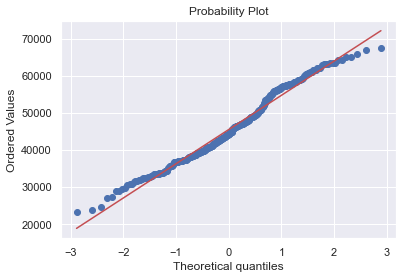

In [174]:
scipy.stats.probplot(crypto_df['BTC-USD_Close'], plot = pylab)
pylab.show()

Before modeling the Bitcoin prices, lets first look at its ACF and PACF to get a glimpse of how many lags we can realistically include in our model. Before this, let's also check for seasonality in the data:

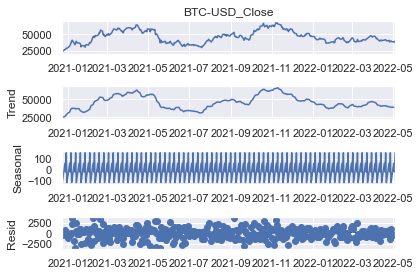

In [184]:

s_bitcoin = seasonal_decompose(crypto_df['BTC-USD_Close'], model = 'additive')
s_bitcoin.plot()
plt.show()

Judging from the seasonal portion of the graph, we have no concrete cyclical patterns in this data. We can see the residuals become less volatile over time as well up until the beginning months of 2022.

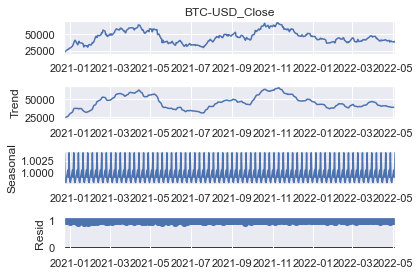

In [187]:
s_bitcoin = seasonal_decompose(crypto_df['BTC-USD_Close'], model = 'multiplicative')
s_bitcoin.plot()
plt.show()

When performing the same using multiplicative decompoisiton, we obtain the same trends for seasonality. Thus, we can ensure that this data is not seasonal.

Now, let's look at the ACF and PACF:

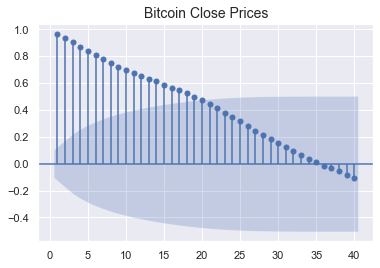

In [343]:
sgt.plot_acf(crypto_df['BTC-USD_Close'], lags=40, zero = False)
plt.title('Bitcoin Close Prices', fontsize=14)
plt.show()

As we go further back in time periods of autocorrelation, the coefficients get closer and closer to the area of insignificance from zero. Our coefficients up until about 17 or 18 periods back will serve as good estimators. Before that however, not so much. 

Next is the PACF for partial autocorrelations on time period records:

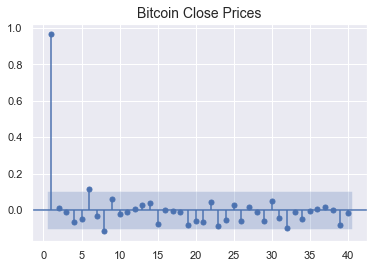

In [345]:
sgt.plot_pacf(crypto_df['BTC-USD_Close'], lags=40, zero = False, method = 'ols')
plt.title('Bitcoin Close Prices', fontsize=14)
plt.show()

Only the first value is significantly different from 0, and we have records going between positive and negative autocorrelation. So, before just one period ago, no other records among the last 40 lags directly affect the current price. 

Let's check if our data follows a stationary process.

In [364]:
sts.adfuller(crypto_df['BTC-USD_Close']) #SHIB

(-2.7565700342661668,
 0.06475020568522961,
 0,
 355,
 {'1%': -3.448905534655263,
  '5%': -2.8697161816205705,
  '10%': -2.5711258103550882},
 6111.08045153683)

In [365]:
bitcoin_diffs = make_difference(crypto_df['BTC-USD_Close']) #SHIB
sts.adfuller(bitcoin_diffs)

(-8.95058527986285,
 8.745844711941012e-15,
 4,
 350,
 {'1%': -3.4491725955218655,
  '5%': -2.8698334971428574,
  '10%': -2.5711883591836733},
 6097.752040742892)

It seems our Bitcoin data here is not significant at a 10% level. It seems to resemble white noise more than anything. It seems that it has a very low chance according to the p-value, that it has a slim chance it comes from a non-stationary process.

To ensure we achieve stationarity, let's apply more transformations:

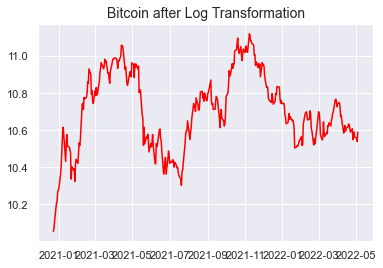

In [370]:
bitcoin_log = np.log(crypto_df['BTC-USD_Close'])
plt.plot(bitcoin_log, color='red')
plt.title('Bitcoin after Log Transformation', fontsize=14)
plt.show()

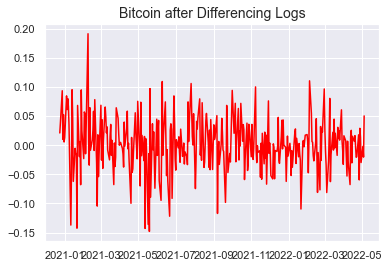

In [371]:
bitcoin_diff_log = bitcoin_log - bitcoin_log.shift()
plt.plot(bitcoin_diff_log, color = 'red')
plt.title('Bitcoin after Differencing Logs', fontsize=14)
plt.show()

In [474]:
#Making a small function to perform both transforms at once:

def log_and_shift(series):
    series_log = np.log(series)
    series_diff_log = series_log.shift()
    return series_diff_log[1:]

It appears that our data is now much more consistent and emulates stationarity. Let's run the ADfuller test on the data now.

In [374]:
bitcoin_diff_log.dropna(inplace=True)
sts.adfuller(bitcoin_diff_log)

(-6.274723122569485,
 3.9259720410856917e-08,
 6,
 348,
 {'1%': -3.4492815848836296,
  '5%': -2.8698813715275406,
  '10%': -2.5712138845950587},
 -1130.5000639648447)

This data now has a T-statistic below the significance levels and an extremely low P-value. This data now emulates stationary data so we can apply some models.

### ARIMA Modeling

Now, we'll try to run some ARMA and other various models on the Bitcoin data.

In [427]:
#llr test onyl applicable to ones of differing df!!

arma_1_model = ARIMA(bitcoin_diff_log, order = (3,1,0))
results_arma_1_model = arma_1_model.fit()
results_arma_1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          BTC-USD_Close   No. Observations:                  355
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 553.530
Date:                Fri, 06 May 2022   AIC                          -1099.060
Time:                        17:55:12   BIC                          -1083.583
Sample:                    12-24-2020   HQIC                         -1092.902
                         - 05-04-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7851      0.051    -15.520      0.000      -0.884      -0.686
ar.L2         -0.5619      0.058     -9.741      0.000      -0.675      -0.449
ar.L3         -0.2843      0.047     -6.007      0.000      -0.377      -0.192
sigma2         0.0026      0.000     15.728      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                10.77
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Seeing as just one coefficient is significant, this is the deepest model we can obtain for prices. Now let's obtain the residuals and plot the ACF.

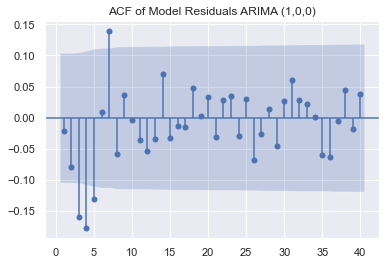

In [384]:
resid_arma_model = results_arma_1_model.resid
sgt.plot_acf(resid_arma_model[1:], zero = False, lags = 40)
plt.title('ACF of Model Residuals ARIMA (1,0,0)')
plt.show()

In [504]:
arma_6_model = ARIMA(bitcoin_diff_log, order = (6,1,0))
results_arma_6_model = arma_6_model.fit()
results_arma_6_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          BTC-USD_Close   No. Observations:                  355
Model:                 ARIMA(6, 1, 0)   Log Likelihood                 574.285
Date:                Fri, 06 May 2022   AIC                          -1134.570
Time:                        19:22:10   BIC                          -1107.485
Sample:                    12-24-2020   HQIC                         -1123.794
                         - 05-04-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8715      0.053    -16.406      0.000      -0.976      -0.767
ar.L2         -0.7277      0.067    -10.866      0.000      -0.859      -0.596
ar.L3         -0.5782      0.069     -8.346      0.000      -0.714      -0.442
ar.L4         -0.4049      0.072     -5.642      0.000      -0.546      -0.264
ar.L5         -0.4126      0.068     -6.110      0.000      -0.545      -0.280
ar.L6         -0.2668      0.055     -4.896      0.000      -0.374      -0.160
sigma2         0.0023      0.000     15.133      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                10.58
Prob(Q):                              0.82   Prob(JB):                         0.01
Heteroskedasticity (H):               0.49   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [388]:
print(LLR_test(arma_1_model, arma_6_model, df=5)) #Perhaps up to that ACF point we found.

0.0


Using our LLR test, we obtain a p-value of 0, and using the amount of lags obtained from the inference of the ACF graph, using an ARIMA (6,1,0) model is the best we can obtain from this type of model.

After modeling manually, let's see what Auto Arima can deliver us. I'll start with a model specifying just a few parameters, and then I will incorporate a more complex model specification.

In [398]:
auto_arima_bitcoin = auto_arima(bitcoin_diff_log,
                            m = 5, max_p = 10, max_q = 10)

In [399]:
auto_arima_bitcoin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                  355
Model:             SARIMAX(1, 0, 0, 5)   Log Likelihood                 589.957
Date:                 Fri, 06 May 2022   AIC                          -1175.914
Time:                         10:40:02   BIC                          -1168.170
Sample:                              0   HQIC                         -1172.833
                                 - 355                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5       -0.1229      0.045     -2.706      0.007      -0.212      -0.034
sigma2         0.0021      0.000     17.075      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                27.59
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It seems we aren't getting much of an improvement from a standard run of Auto Arima. I'll try to change a few parameters.

In [400]:
auto_arima_bitcoin = auto_arima(bitcoin_diff_log, 
                            m = 5, max_order = None, max_p = 8, max_q = 8, max_d = 2,
                            max_P = 4, max_Q = 4, max_D = 2, maxiter = 50, alpha = 0.05,
                            n_jobs = -1, trend = 'ct')

In [401]:
auto_arima_bitcoin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  355
Model:             SARIMAX(0, 0, [1], 5)   Log Likelihood                 591.571
Date:                   Fri, 06 May 2022   AIC                          -1175.142
Time:                           10:40:53   BIC                          -1159.654
Sample:                                0   HQIC                         -1168.981
                                   - 355                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0080      0.004      2.105      0.035       0.001       0.015
drift      -3.687e-05    2.2e-05     -1.677      0.094      -8e-05    6.23e-06
ma.S.L5       -0.1317      0.047     -2.810      0.005      -0.224      -0.040
sigma2         0.0021      0.000     16.809      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                33.10
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It seems Auto Arima could not find what we did. This may be an indicator that sometimes we can't simply rely on an automated way of doing something. Auto Arima also evaluates models on the basis of only one metric, the default being AIC.

Now, how well will the ARCH model do?

### ARCH Modeling

In [297]:
bitcoin_sq_returns = crypto_df['BTC-USD_Return'].mul(crypto_df['BTC-USD_Return'])
crypto_df['BTC-USD_Sq_Return'] = bitcoin_sq_returns

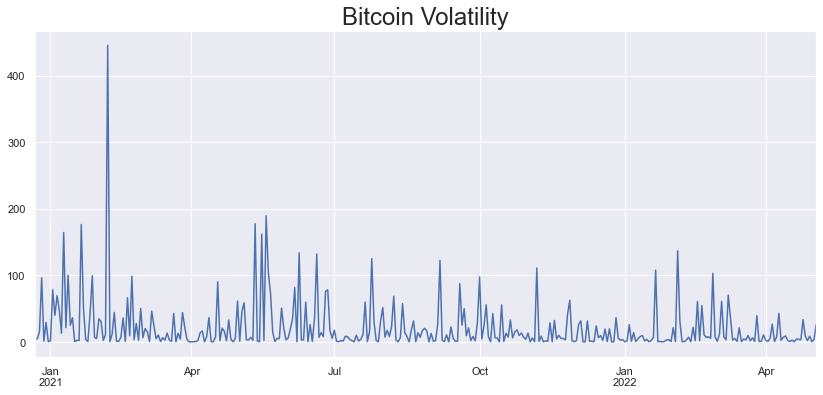

In [306]:
crypto_df['BTC-USD_Sq_Return'].plot(figsize=(14, 6))
plt.title('Bitcoin Volatility', fontsize=24)
plt.show()

From looking at the volatility graph for BitCoin, we can see there are several quick spikes, which makes it a bit more difficult to predict future values.

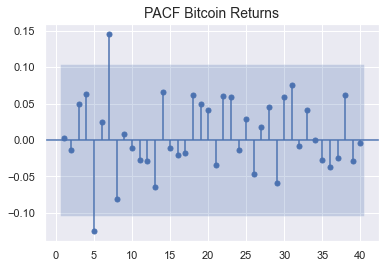

In [336]:
sgt.plot_pacf(crypto_df['BTC-USD_Return'], lags=40, zero = False, method = 'ols')
plt.title('PACF Bitcoin Returns', fontsize=14)
plt.show()

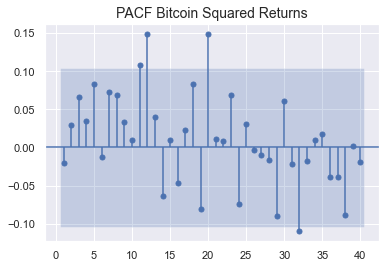

In [311]:
sgt.plot_pacf(crypto_df['BTC-USD_Sq_Return'], lags=40, zero = False, method = 'ols')
plt.title('PACF Bitcoin Squared Returns', fontsize=14)
plt.show()

Creating squared returns for the Bitcoin closing prices returned some interesting elements. We can see spikes in volatility, and some lags that are significant are not within recent time periods.

In [402]:
bitcoin_diff_log_returns = bitcoin_diff_log.pct_change(1).mul(100)

Since the original Bitcoin data had more periods of variation, let's model its returns.

In [418]:
model_arch_1 = arch_model(crypto_df['BTC-USD_Return'][1:], vol = 'ARCH', p = 1, q = 1)
results_arch_1 = model_arch_1.fit()
results_arch_1.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1056.1800934611895
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1048.0487783378803
Iteration:      3,   Func. Count:     14,   Neg. LLF: 1103.3304597100644
Iteration:      4,   Func. Count:     20,   Neg. LLF: 1047.4848073150101
Iteration:      5,   Func. Count:     24,   Neg. LLF: 1047.4407424068324
Iteration:      6,   Func. Count:     28,   Neg. LLF: 1047.4401183063887
Iteration:      7,   Func. Count:     32,   Neg. LLF: 1047.4401168553122
Iteration:      8,   Func. Count:     35,   Neg. LLF: 1047.440117091467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1047.4401168553122
            Iterations: 8
            Function evaluations: 35
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:         BTC-USD_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1047.44
Distribution:                  Normal   AIC:                           2100.88
Method:            Maximum Likelihood   BIC:                           2112.50
                                        No. Observations:                  355
Date:                Fri, May 06 2022   Df Residuals:                      354
Time:                        10:53:51   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2578      0.250      1.033      0.302 [ -0.232,  0.747]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega         21.3957      2.563      8.347  7.024e-17 [ 16.372, 26.420]
alpha[1]       0.0000  7.281e-02      0.000      1.000 [ -0.143,  0.143]
========================================================================

Covariance estimator: robust
"""

It appears we don't get much help from ARCH models. Since Bitcoin is an very volatile currency in the history above, I believe we will have to rely on some deep learning technique to model it with high accuracy of predicted prices.

### Forecasting with ARIMA (6,1,0)

In [433]:
bitcoin_diff_log[:invasion_date]

2020-12-24    0.021058
2020-12-25    0.038386
2020-12-28    0.093596
2020-12-29    0.010198
2020-12-30    0.052625
                ...   
2022-02-18   -0.012587
2022-02-21   -0.076703
2022-02-22    0.032135
2022-02-23   -0.026184
2022-02-24    0.027400
Freq: B, Name: BTC-USD_Close, Length: 306, dtype: float64

In [823]:
#Creating the transformed and split versions of data for our endogenous variable.
bitcoin_diff_log = log_and_shift(crypto_df['BTC-USD_Close'])
df_train, df_test = bitcoin_diff_log[:invasion_date], bitcoin_diff_log[invasion_date:]

In [824]:
#potential exogenous variables for which to use in modeling. We can create more here if need be.

litecoin_diff_log = log_and_shift(crypto_df['LTC-USD_Close']) 
litecoin_train, litecoin_test = litecoin_diff_log[:invasion_date], litecoin_diff_log[invasion_date:]

etherium_diff_log = log_and_shift(crypto_df['ETH-USD_Close'])
etherium_train, etherium_test = etherium_diff_log[:invasion_date], etherium_diff_log[invasion_date:]

lidosteth_diff_log = log_and_shift(crypto_df['STETH-USD_Close'])
lidosteth_train, lidosteth_test = lidosteth_diff_log[:invasion_date], lidosteth_diff_log[invasion_date:]

In [825]:
exog_data = pd.concat([litecoin_train, etherium_train, lidosteth_train], axis=1)

In [826]:
exog_test = pd.concat([litecoin_test, etherium_test, lidosteth_test], axis=1)

In [827]:
#Passing the values of the train data for Bitcoin into a list.
values = [x for x in df_train]
predictions = []
originals = []
errors = []

for t in range(len(df_test)):
    model = ARIMA(values, order = (6,1,0)) #Using best discovered ARIMA model from before 
    model_fit = model.fit()
    
    #Making a forecast using each value from the predicted output and passing it back into our values list.
    output = model_fit.forecast() 
    pred_value = output[0]
    
    original_value = df_test.iloc[t]
    values.append(original_value)
    
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)
    
    #Calculating the error in order to compare different runs of this cell with different values.
    error = ((abs(pred_value - original_value)) / original_value) * 100
    errors.append(error)
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
print('Mean Error in BitCoin predictions post Invasion Date: {}'.format(sum(errors) / float(len(errors))))

Mean Error in BitCoin predictions post Invasion Date: 2.7147182612999523


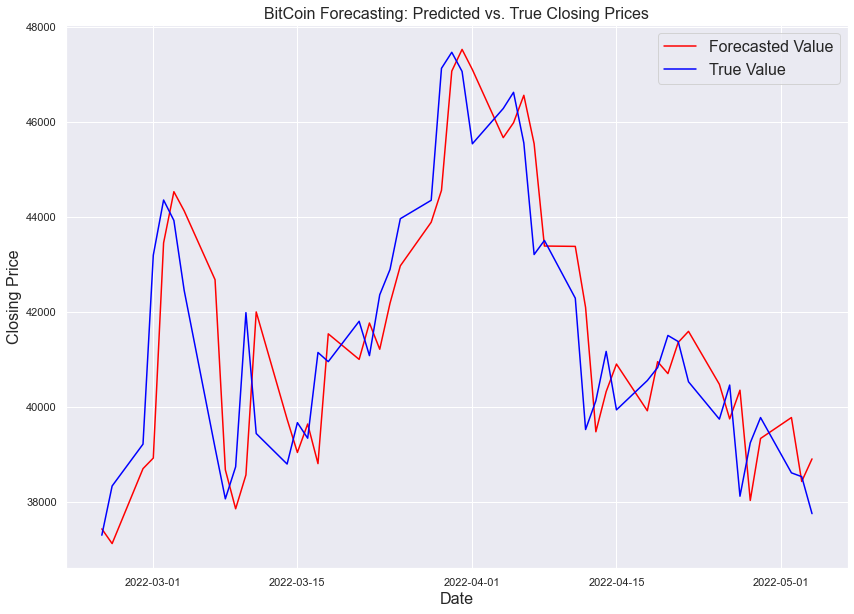

In [828]:
plt.figure(figsize=(14,10))

labels = {'True Value', 'Forecasted Value'}
plt.plot(df_test.index, predictions, color='red')
plt.plot(df_test.index, originals, color='blue')
plt.title('BitCoin Forecasting: Predicted vs. True Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Closing Price', fontsize=16)

plt.legend(labels, fontsize=16)
plt.show()

### Modeling Auto Arima w/ Exogenous Variables

Forecasting seems to match the data quite well, including the trend. Next, we'll use Auto Arima to generate a model along with all exogenous variables created for this example.

In [817]:
auto_model = auto_arima(df_train, exogenous = exog_data, #crypto_df['BTC-USD_Close'][:invasion_date], exog_data[1:]
                        start_p = 1, start_q = 1, 
                        test = 'adf',
                        d = None,
                        seasonal = True,
                        start_P = 0,
                        D = 0,
                        trace = True,
                        error_action = 'ignore',
                        suppress_warnings = True,
                        stepwise = True,
                        m = 5, max_q = 5, max_P = 6, max_Q = 6)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=-1326.836, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-1332.649, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-1328.850, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-1328.844, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-1334.621, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=-1330.827, Time=0.21 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=-1330.821, Time=0.24 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=-1328.784, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=-1330.691, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=-1330.692, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=-1328.687, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[5]          
Total fit time: 2.082 seconds


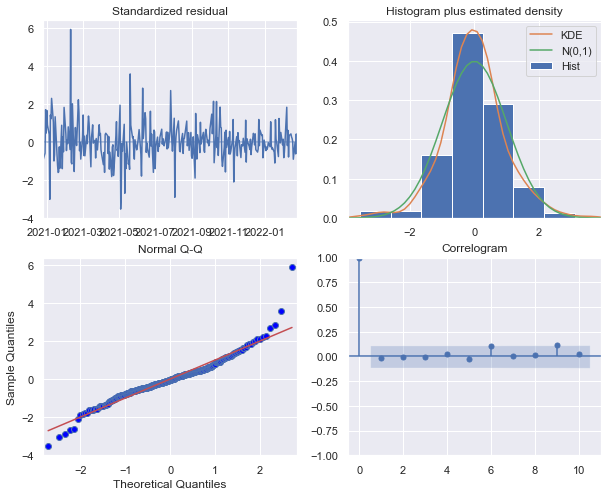

In [818]:
auto_model.plot_diagnostics(figsize=(10, 8))
plt.show()

The data emulates a standard distribution, with some noise in the residuals.

In [819]:
df_auto_pred = pd.DataFrame(auto_model.predict(n_periods = len(df_test),
                            exogenous = exog_test),
                            index = df_test.index)

In [820]:
#Reverse transform code:
df_auto_pred = np.exp(df_auto_pred.shift(-1))
df_test = np.exp(df_test.shift(-1))

df_auto_pred.dropna(axis=0, inplace=True)
df_test.dropna(axis=0, inplace=True)

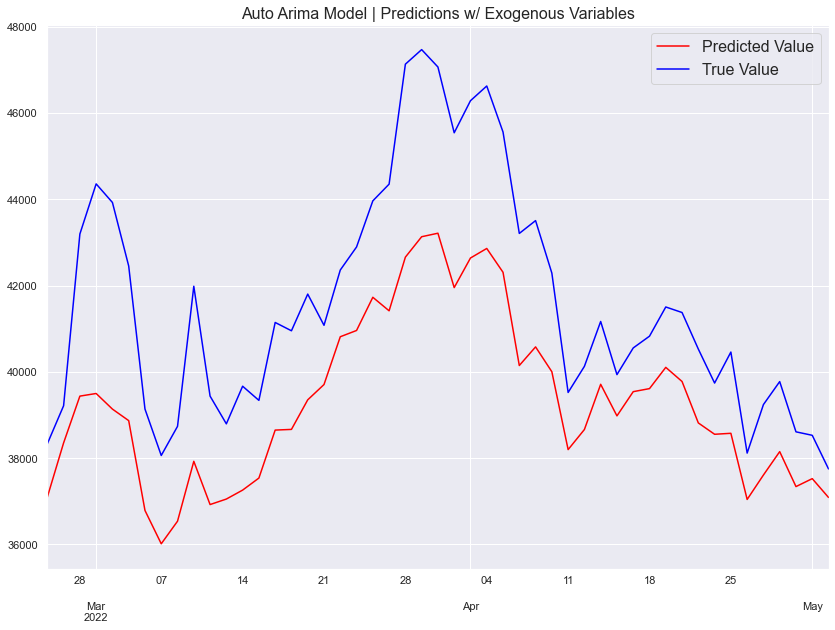

In [821]:
df_auto_pred.plot(figsize=(14,10), color = 'red')
df_test.plot(color = 'blue') #try df_test #crypto_df['BTC-USD_Close'][invasion_date:]
labels = {'True Value', 'Predicted Value'}

plt.title('Auto Arima Model | Predictions w/ Exogenous Variables', fontsize=16)
plt.legend(labels, fontsize=16)
plt.show()

In [ ]:
#reverse transform implemented.

We can see models with exogenous variables being used give us predictions that match the data much better. The one pitfall of this particular model is that the predictions are matching the trend quite well but in many early cases are undershooting the real values. This could be attributed to the BitCoin values being much higher than the other exogenous variables being used.

All the data including exogenous values have been log and difference transformed, so all data used is on the same scale. I believe in this particular example, since the exogenous values are lower than the BitCoin transformed values, those exogenous values are weighing down the predictions of BitCoin, thus predicting lower than the real value. 

If we predict a cryptocurrency that is similar in value to exogenous variables used, I think we will get a much better match. I did already try with non-transformed values and the same prediction trend stands.

## Closing Remarks:
* We saw from the analysis of the time series of currencies that several moved in the same directions at the same time periods. Each spiked and dipped within the 4th quarter of 2021. Then, since the Russian invasion, each of the currencies seems to have kept within a range at the time of me writing this notebook (May 6th, 2022). Therefore, perhaps the build up of tensions and the eventual invasion partially contributed to the behavior of bitcoin during these time periods.


* In attempt to model BitCoin (as an example) with other currencies using some well-known models and algorithms, we found that an ARIMA (6,1,0) modeled the data well when using data dated back to the earliest time period of data being present with the currencies we chose. I wanted to try and model the prices using the dates after the invasion as a test set for predictions.


* Exogenous variables help match the trend much better to get an accurate model with Auto Arima. 


This sets us up for what I will do in the next notebook, where we will use Deep Learning to make predictions of a currency with the choice of the user. If possible, I may try to allow for custom input of exogenous variables to then go into the StreamLit application. 

The primary gist of this notebook was to analyze crypto trends around the time of the Russian Invasion. Next, we will try to productionize being able to coalesce currencies together at the user's discretion.